In [106]:
import os
import torch
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics 
import os 
from torchvision.io import read_image
from sys import getsizeof
from torch.utils.data import random_split,Dataset,DataLoader 
from torchvision import transforms

In [107]:
train_location = "./Project Data/Dataset_Student/train/"
val_location = "./Project Data/Dataset_Student/val/"

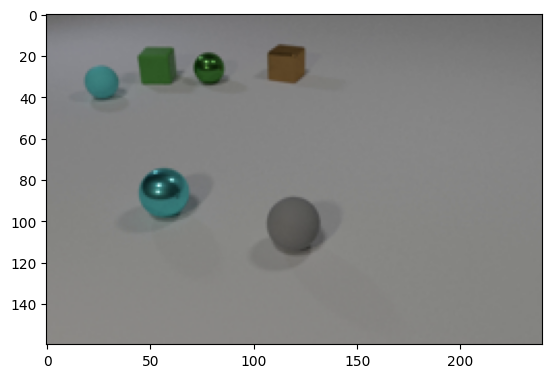

In [108]:
plt.imshow(iio.imread(os.path.join(train_location,"video_0/image_21.png")))

**Getting each mask**

In [109]:
def split_video_mask(video_folder):
    '''split_video_mask Creats a list of tuples (image,mask)

    :param video_folder: directory to video folder
    :type video_folder: path
    :return: list of tuples of form (pytorch tensor, pytorch tensor) (size [3, 160, 240],[160, 240])
    '''
    directory = video_folder
    
    img_mask_dict = {}
    list_of_segments = []

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            index = str(os.path.basename(file)[6:-4])
            img = read_image(os.path.join(directory,file))
            img_mask_dict[index] = img.to(torch.get_default_dtype())
 

        if filename.endswith(".npy"):
            #print(os.path.join(directory, filename))
            mask = torch.from_numpy(np.load(os.path.join(directory,file))).to(torch.get_default_dtype())

    for key,val in img_mask_dict.items():
        list_of_segments.append((val,mask[int(key)]))

    
    return list_of_segments

In [110]:
subdir_list = os.listdir(train_location)
mask_list = []

for subdir in subdir_list:
    train_mask_list = split_video_mask(os.path.join(train_location,subdir))
    mask_list = mask_list + train_mask_list

subdir_list_val_data = os.listdir(val_location)
for subdir in subdir_list_val_data:
    val_mask_list = split_video_mask(os.path.join(val_location,subdir))
    mask_list = mask_list + val_mask_list

In [111]:
class Semantic_Segmentation_Dataset(Dataset):
    def __init__(self, mask_list,input_transform = None,target_transform = None):
        self.mask_list = mask_list
        self.input_transform = input_transform 
        self.target_transform = target_transform 

    def __len__(self):
        return len(self.mask_list)
    
    def __getitem__(self, idx):
        image = self.mask_list[idx][0]
        target = self.mask_list[idx][1].view(1,self.mask_list[idx][1].shape[0],-1)

        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

In [112]:
import random 
data_sample = random.sample(mask_list,1000)
input_mean = torch.mean(torch.Tensor(data_sample[0][0]),dim=[1,2])
input_std = torch.std(torch.Tensor(data_sample[0][0]),dim=[1,2])


height = mask_list[0][0].shape[1]
width = mask_list[0][0].shape[2]

In [113]:
input_transform = transforms.Compose([
                                   transforms.Normalize(input_mean,input_std),
                                   transforms.Resize([256, 256],antialias=True)])


ss_dataset = Semantic_Segmentation_Dataset(mask_list, 
                                           input_transform=transforms.Normalize(input_mean,input_std),
                                           target_transform=None
                                           #target_transform= transforms.Resize([256, 256],antialias=True)
                                           )

generator = torch.Generator().manual_seed(10)

train_set, test_set = random_split(ss_dataset,[.7, .3],generator=generator)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [114]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights=None)
model.classifier._modules['4'] = torch.nn.Conv2d(256, 49, kernel_size=(1, 1), stride=(1, 1))
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)

Using cache found in C:\Users\Miles/.cache\torch\hub\pytorch_vision_v0.10.0


In [123]:
num_epochs = 15 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
best_val_jac = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        predicted = torch.nn.functional.softmax(model(data)['out'],dim=1)
        predicted = torch.argmax(predicted,dim=1).view(-1,1,height,width)

        loss = jaccard(predicted,labels).requires_grad_(True)
        #loss.requires_grad =  True
        loss.backward()
        optimizer.step

    model.eval()

    with torch.no_grad():
        for data in test_dataloader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            predicted = torch.nn.functional.softmax(model(data)['out'],dim=1)
            predicted = torch.argmax(predicted,dim=1).view(-1,1,height,width)
            
    val_jac = 100 * jaccard(predicted,labels)
    print(f"Epoch: {epoch + 1}, Validation Accuracy: {val_jac:.2f}%")

    # Save the best model
    if val_jac > best_val_jac:
        best_val_acc = val_jac
        torch.save(model.state_dict(), "best_model.pth")

KeyboardInterrupt: 